# Data prep

## This section is to prepare the data into the proper format for time series forecasting using TensorFlow

### There are many ways to architect a ML solution for TS forecasting - this one will use one of the most cutting edge methods LSTM (long/short term memory) models in a sequence to sequence architecture (seq2seq). 

Seq 2 seq is popular in many application surrounding machine translation (english to french, etc..). This makes sense as we will be taking a time series sequence of inputs to predict a time series output of predicted values

For this example, we will be using the Melbourne Daily min tempuratures dataset 
https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

to illustrate how this technique works. Note that there is only one feature and target/label here, but LSTMs take 3D shapes (n_observations, n_timesteps, n_features), and we will only be dealing with 1 element for the features



# Import and prep the data

Using TensorFlow backend.


,date,temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8
7,1981-01-08,17.4
8,1981-01-09,21.8
9,1981-01-10,20.0


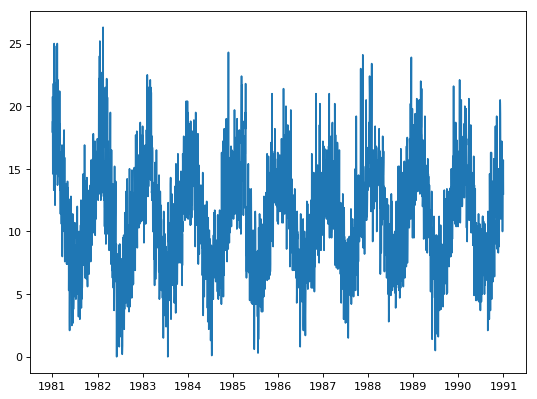

In [1]:
from matplotlib import pyplot as plt
import re
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import keras


%matplotlib inline

pandas_data = pd.read_csv('data/daily-minimum-temperatures-in-me.csv', sep=';', encoding='utf-8' )

columns = ['date', 'temp']

pandas_data.columns = columns

pandas_data['date'] = pd.to_datetime(pandas_data['date'])

pandas_data['temp'] = pandas_data['temp'].str.extract('(\d+.\d)', expand=False) #funky characters in data

pandas_data['temp'] = pandas_data['temp'].astype('float32')

pandas_data['temp'] = pandas_data['temp'].apply(lambda x: round(x,1)) #fp conversion created some noise
 
    
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(pandas_data['date'],pandas_data['temp'])


# pyplot.show
pandas_data.head(10)

In [2]:
pandas_np = pandas_data['temp'].values

dates = pandas_data['date'].values

nobs = pandas_np.shape[0]

train_obs = int(0.75 * nobs)

# we need to create a function that reshapes the data to have each observation as a time series
# and each prediction as a time series
# inspiration here: https://stackoverflow.com/questions/21229503/creating-an-numpy-matrix-with-a-lag

def lagLead4LSTM(arr, window, axis=-1):
    """
    return a running view of length 'window' over 'axis'
    the returned array has an extra last dimension, which spans the window
    """
    shape = list(arr.shape)
    shape[axis] -= (window-1)
    assert(shape[axis]>0)
    return np.lib.index_tricks.as_strided(
        arr,
        shape + [window],
        arr.strides + (arr.strides[axis],))

lag = 90
lead = 30

x1  = lagLead4LSTM(pandas_np, lag)

x = x1[:-lead,] # get rid of last observations with no lags
    

In [3]:


pandas_np.shape, x1.shape, x.shape, pandas_np[lag-1:,].shape


((3650,), (3561, 90), (3531, 90), (3561,))

In [4]:
y = lagLead4LSTM(pandas_np[lag:,],lead) 

print(x[4], y[3]) 
#last element should be same as first (tommorows data = first datapoint in y)

"the shapes for x are: {} and the shapes for y are: {}".format(x.shape, y.shape)

[15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3 16.7 21.5 25.  20.7 20.6 24.8
 17.7 15.5 18.2 12.1 14.4 16.  16.5 18.7 19.4 17.2 15.5 15.1 15.4 15.3
 18.8 21.9 19.9 16.6 16.8 14.6 17.1 25.  15.  13.7 13.9 18.3 22.  22.1
 21.2 18.4 16.6 16.1 15.7 16.6 16.5 14.4 14.4 18.5 16.9 17.5 21.2 17.8
 18.6 17.  16.  13.3 14.3 11.4 16.3 16.1 11.8 12.2 14.7 11.8 11.3 10.6
 11.7 14.2 11.2 16.9 16.7  8.1  8.   8.8 13.4 10.9 13.4 11.  15.  15.7
 14.5 15.8 16.7 16.8 17.5 17.1] [17.1 18.1 16.6 10.  14.9 15.9 13.   7.6 11.5 13.5 13.  13.3 12.1 12.4
 13.2 13.8 10.6  9.  10.   9.8 11.5  8.9  7.4  9.9  9.3  9.9  7.4  8.6
 11.9 14. ]


'the shapes for x are: (3531, 90) and the shapes for y are: (3531, 30)'

# The data is now in the shape for us to to a seq2seq model
## We are using the last 30 days to predict the next 7 days

First, we need to split the data and scale it on a 0-1

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

scaler = scaler.fit(pandas_np.reshape(-1,1))

pandas_np_scaled = scaler.transform(pandas_np.reshape(-1,1))

pandas_np_scaled

trainN = int(0.75 * pandas_np_scaled.shape[0]) # will take only the first 75 percent days

trainRaw = pandas_np_scaled[:trainN,-1]

testRaw = pandas_np_scaled[trainN+1:,-1]

trainDates = dates[:trainN]

testDates = dates[trainN+1:]

In [6]:
"The number of train cases are {} days, test cases are {} days".format(trainRaw.shape[0], testRaw.shape[0])

'The number of train cases are 2737 days, test cases are 912 days'

In [7]:
#reapply the transform above now we are split and scaled
lag = 90
lead = 30

def reshapeDataXY(rawData, lag=lag, lead=lead):
    x = lagLead4LSTM(rawData, lag)
    x = x[:-lead,]
    xs1, xs2 = x.shape
    x = x.reshape(xs1, xs2, 1) #need 1 for the one feature
    y = lagLead4LSTM(rawData[lag:,],lead) 
    ys1, ys2 = y.shape
    y = y.reshape(ys1, ys2, 1)
    return x, y


xTrain, yTrain = reshapeDataXY(trainRaw)
xTest, yTest = reshapeDataXY(testRaw)

# create padded input target sequence
decodeY = np.zeros((yTrain.shape))
decodeY[:,1:,:] = yTrain[:,:-1,:]
# print(yTrain[2])
# print(decodeY[2])

In [8]:
print(xTrain.shape, yTrain.shape, decodeY.shape)

(2618, 90, 1) (2618, 30, 1) (2618, 30, 1)


# Now to setup the LSTM seq2seq model
from: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

Here is an example of the architecture in the context of machine translation:

![](https://blog.keras.io/img/seq2seq/seq2seq-inference.png)

An excellent explanation of GRUs and LSTMs are here

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

![](https://cdn-images-1.medium.com/max/1600/1*VOXRGhOShoWWks6ouoDN3Q.gif)

In [26]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RNN, Dropout


latent_dim = 64

num_encoder_tokens = 1
num_decoder_tokens = 1

input_layers = [64, 32]
dropout = .5 #set to zero if you don't want to use dropout
output_layers = [64, 32]

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_sequences=True)(encoder_inputs)
encoder = Dropout(0.5)(encoder)
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs1, _, _ = decoder_lstm1(decoder_inputs, initial_state=encoder_states)
do1 = Dropout(.5)(decoder_outputs1)
decoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs2, _, _ = decoder_lstm2(do1, initial_state=encoder_states)#, intial_state=[h1,c1])
do2 = Dropout(.5)(decoder_outputs2)
decoder_dense = Dense(num_decoder_tokens, activation='linear')
decoder_output = decoder_dense(do2)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_output)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, None, 64)     16896       input_7[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, None, 64)     0           lstm_5[0][0]                     
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_6 (LS

In [27]:
# Run training

batch_size = 512
epochs = 1000

#research - forced teaching (shifted by one input for decoder) does not perform well
decodeY = np.zeros(decodeY.shape)

learning_rate = 0.01
decay = 1e-7 # Learning rate decay
beta2 = .90

optimizer = keras.optimizers.Adam(lr=learning_rate, decay=decay, beta_2=beta2)

model.compile(optimizer=keras.optimizers.RMSprop(), loss='mean_absolute_error')
history = model.fit([xTrain, decodeY], yTrain,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=.05)

Train on 2487 samples, validate on 131 samples
Epoch 1/1000
2487/2487 [==============================] - 7s 3ms/step - loss: 0.2518 - val_loss: 0.2021
Epoch 2/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.2124 - val_loss: 0.1742
Epoch 3/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.2092 - val_loss: 0.1691
Epoch 4/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.2063 - val_loss: 0.1707
Epoch 5/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1919 - val_loss: 0.1661
Epoch 6/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1987 - val_loss: 0.1701
Epoch 7/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1954 - val_loss: 0.1668
Epoch 8/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1963 - val_loss: 0.1676
Epoch 9/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1904 - val_loss: 0.1661
Epoch 10/1000
248

2487/2487 [==============================] - 3s 1ms/step - loss: 0.1732 - val_loss: 0.1701
Epoch 79/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1754 - val_loss: 0.1772
Epoch 80/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1752 - val_loss: 0.1750
Epoch 81/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1738 - val_loss: 0.1695
Epoch 82/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1739 - val_loss: 0.1832
Epoch 83/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1731 - val_loss: 0.1864
Epoch 84/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1771 - val_loss: 0.1670
Epoch 85/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1710 - val_loss: 0.1864
Epoch 86/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1737 - val_loss: 0.2046
Epoch 87/1000
2487/2487 [==============================] - 3s 1ms/ste

2487/2487 [==============================] - 3s 1ms/step - loss: 0.1665 - val_loss: 0.1763
Epoch 156/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1689 - val_loss: 0.1738
Epoch 157/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1644 - val_loss: 0.1810
Epoch 158/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1662 - val_loss: 0.1800
Epoch 159/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1660 - val_loss: 0.1950
Epoch 160/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1656 - val_loss: 0.1804
Epoch 161/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1686 - val_loss: 0.1824
Epoch 162/1000
2487/2487 [==============================] - 4s 1ms/step - loss: 0.1652 - val_loss: 0.1774
Epoch 163/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1644 - val_loss: 0.1792
Epoch 164/1000
2487/2487 [==============================] - 3

2487/2487 [==============================] - 3s 1ms/step - loss: 0.1606 - val_loss: 0.1810
Epoch 233/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1601 - val_loss: 0.1864
Epoch 234/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1624 - val_loss: 0.1843
Epoch 235/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1619 - val_loss: 0.1844
Epoch 236/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1624 - val_loss: 0.1938
Epoch 237/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1600 - val_loss: 0.1797
Epoch 238/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1609 - val_loss: 0.1838
Epoch 239/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1618 - val_loss: 0.1852
Epoch 240/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1610 - val_loss: 0.1848
Epoch 241/1000
2487/2487 [==============================] - 3

2487/2487 [==============================] - 3s 1ms/step - loss: 0.1555 - val_loss: 0.1954
Epoch 310/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1569 - val_loss: 0.2004
Epoch 311/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1547 - val_loss: 0.1890
Epoch 312/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1567 - val_loss: 0.1962
Epoch 313/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1573 - val_loss: 0.2052
Epoch 314/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1575 - val_loss: 0.1977
Epoch 315/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1566 - val_loss: 0.1984
Epoch 316/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1546 - val_loss: 0.2002
Epoch 317/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1563 - val_loss: 0.2003
Epoch 318/1000
2487/2487 [==============================] - 3

2487/2487 [==============================] - 3s 1ms/step - loss: 0.1520 - val_loss: 0.2088
Epoch 387/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1520 - val_loss: 0.2040
Epoch 388/1000
2487/2487 [==============================] - 4s 1ms/step - loss: 0.1500 - val_loss: 0.2015
Epoch 389/1000
2487/2487 [==============================] - 4s 2ms/step - loss: 0.1519 - val_loss: 0.2061
Epoch 390/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1548 - val_loss: 0.2068
Epoch 391/1000
2487/2487 [==============================] - 4s 1ms/step - loss: 0.1510 - val_loss: 0.2016
Epoch 392/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1506 - val_loss: 0.2044
Epoch 393/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1498 - val_loss: 0.2027
Epoch 394/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1509 - val_loss: 0.2054
Epoch 395/1000
2487/2487 [==============================] - 3

2487/2487 [==============================] - 3s 1ms/step - loss: 0.1470 - val_loss: 0.1971
Epoch 464/1000
2487/2487 [==============================] - 4s 2ms/step - loss: 0.1475 - val_loss: 0.1968
Epoch 465/1000
2487/2487 [==============================] - 4s 2ms/step - loss: 0.1468 - val_loss: 0.2012
Epoch 466/1000
2487/2487 [==============================] - 4s 2ms/step - loss: 0.1464 - val_loss: 0.1941
Epoch 467/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1471 - val_loss: 0.2050
Epoch 468/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1464 - val_loss: 0.1960
Epoch 469/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1468 - val_loss: 0.1986
Epoch 470/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1456 - val_loss: 0.2045
Epoch 471/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1463 - val_loss: 0.1933
Epoch 472/1000
2487/2487 [==============================] - 3

2487/2487 [==============================] - 3s 1ms/step - loss: 0.1456 - val_loss: 0.2018
Epoch 541/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1407 - val_loss: 0.1900
Epoch 542/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1424 - val_loss: 0.2011
Epoch 543/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1418 - val_loss: 0.1948
Epoch 544/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1440 - val_loss: 0.2005
Epoch 545/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1420 - val_loss: 0.1950
Epoch 546/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1426 - val_loss: 0.1961
Epoch 547/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1423 - val_loss: 0.1930
Epoch 548/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1424 - val_loss: 0.2017
Epoch 549/1000
2487/2487 [==============================] - 3

2487/2487 [==============================] - 3s 1ms/step - loss: 0.1391 - val_loss: 0.1896
Epoch 618/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1390 - val_loss: 0.1963
Epoch 619/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1388 - val_loss: 0.1890
Epoch 620/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1395 - val_loss: 0.1940
Epoch 621/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1391 - val_loss: 0.1941
Epoch 622/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1381 - val_loss: 0.1936
Epoch 623/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1402 - val_loss: 0.1954
Epoch 624/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1384 - val_loss: 0.2003
Epoch 625/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1379 - val_loss: 0.1963
Epoch 626/1000
2487/2487 [==============================] - 3

2487/2487 [==============================] - 3s 1ms/step - loss: 0.1362 - val_loss: 0.1841
Epoch 695/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1348 - val_loss: 0.1891
Epoch 696/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1345 - val_loss: 0.1856
Epoch 697/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1362 - val_loss: 0.1895
Epoch 698/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1356 - val_loss: 0.1895
Epoch 699/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1357 - val_loss: 0.1897
Epoch 700/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1348 - val_loss: 0.1875
Epoch 701/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1393 - val_loss: 0.1854
Epoch 702/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1370 - val_loss: 0.1925
Epoch 703/1000
2487/2487 [==============================] - 3

2487/2487 [==============================] - 3s 1ms/step - loss: 0.1320 - val_loss: 0.1831
Epoch 772/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1310 - val_loss: 0.1885
Epoch 773/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1339 - val_loss: 0.1903
Epoch 774/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1324 - val_loss: 0.1851
Epoch 775/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1350 - val_loss: 0.1876
Epoch 776/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1340 - val_loss: 0.1812
Epoch 777/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1323 - val_loss: 0.1870
Epoch 778/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1316 - val_loss: 0.1892
Epoch 779/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1327 - val_loss: 0.1808
Epoch 780/1000
2487/2487 [==============================] - 3

2487/2487 [==============================] - 3s 1ms/step - loss: 0.1336 - val_loss: 0.1873
Epoch 849/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1292 - val_loss: 0.1940
Epoch 850/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1307 - val_loss: 0.1873
Epoch 851/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1294 - val_loss: 0.1873
Epoch 852/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1292 - val_loss: 0.1931
Epoch 853/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1308 - val_loss: 0.1923
Epoch 854/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1289 - val_loss: 0.1874
Epoch 855/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1294 - val_loss: 0.1902
Epoch 856/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1286 - val_loss: 0.1872
Epoch 857/1000
2487/2487 [==============================] - 3

2487/2487 [==============================] - 3s 1ms/step - loss: 0.1272 - val_loss: 0.1982
Epoch 926/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1252 - val_loss: 0.2077
Epoch 927/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1270 - val_loss: 0.1944
Epoch 928/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1274 - val_loss: 0.1935
Epoch 929/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1271 - val_loss: 0.1952
Epoch 930/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1270 - val_loss: 0.1948
Epoch 931/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1261 - val_loss: 0.2016
Epoch 932/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1256 - val_loss: 0.1970
Epoch 933/1000
2487/2487 [==============================] - 3s 1ms/step - loss: 0.1270 - val_loss: 0.1959
Epoch 934/1000
2487/2487 [==============================] - 3

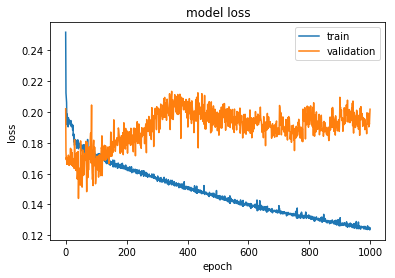

In [28]:
# summarize history for accuracy
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

# Inference setup 


In [32]:
encoder_model = Model(encoder_inputs, encoder_states)


decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs1 = decoder_lstm1(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_outputs2, output_h, ouput_c = decoder_lstm2(decoder_outputs1, initial_state=decoder_states_inputs)

decoder_states = [output_h, ouput_c]
decoder_outputs3 = decoder_dense(decoder_outputs2)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs3] + decoder_states)

In [33]:
def decode_sequence(x, length_forecast=7, pred_batch_size=1):
    # Encode the input as state vectors.
    y_pred = []
    
    
    decoder_input = np.zeros((x.shape[0], 1, 1))
    
    states = encoder_model.predict(x)
    
    for i in range(length_forecast):

        outputs_and_states = decoder_model.predict(
                [decoder_input] + states, batch_size=pred_batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]
        y_pred.append(output)
        decoder_input = output
        #decoder_input[:,i,:] = output[0][i][0]
         # Update states
        #states = [h, c]


    return np.concatenate(y_pred, axis=1)

Actual, Predicted Values:
50.9 , 47.278202
43.16 , 46.678024
41.18 , 46.2361
49.1 , 45.843616
53.06 , 45.53695
48.56 , 45.33393
45.14 , 45.211826
49.46 , 45.11048
48.92 , 44.96731
50.0 , 44.749554
51.620000000000005 , 44.465996
51.8 , 44.156876
51.620000000000005 , 43.87159
46.4 , 43.64759
52.16 , 43.499413
45.5 , 43.41611
44.96 , 43.374615
55.76 , 43.350693
55.22 , 43.32682
48.92 , 43.295
50.36 , 43.2558
49.1 , 43.214443
54.32 , 43.17675
50.36 , 43.14642
56.120000000000005 , 43.124226
52.879999999999995 , 43.108658
46.4 , 43.097206
48.2 , 43.087547
48.74 , 43.07824
56.3 , 43.068832


/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


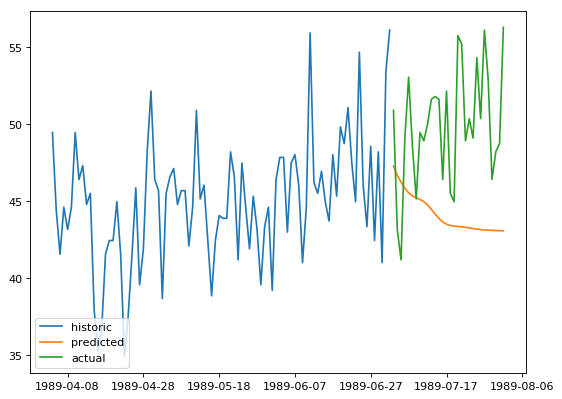

Actual, Predicted Values:
46.4 , 50.562073
46.58 , 50.54446
50.0 , 50.69351
47.3 , 50.91306
54.5 , 51.228745
59.0 , 51.65225
55.94 , 52.142582
51.8 , 52.629192
53.42 , 53.046646
46.94 , 53.359726
49.46 , 53.568504
52.34 , 53.69722
54.5 , 53.77929
48.92 , 53.84648
52.52 , 53.923534
55.76 , 54.026474
56.84 , 54.16302
60.8 , 54.333916
51.620000000000005 , 54.534718
53.42 , 54.757767
54.32 , 54.99401
55.76 , 55.234562
59.89999999999999 , 55.471733
70.88 , 55.69957
58.82 , 55.913925
57.92 , 56.112244
55.22 , 56.293236
55.58 , 56.456562
57.2 , 56.60252
64.22 , 56.731853


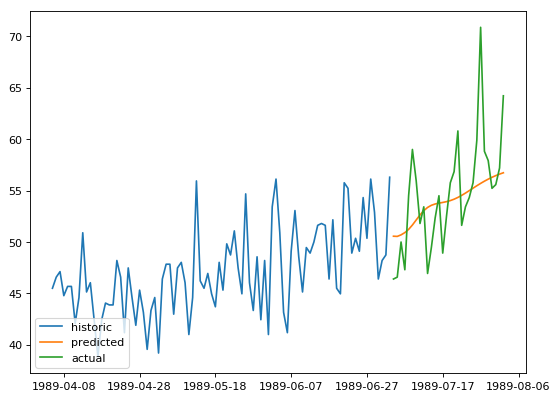

Actual, Predicted Values:
63.86 , 53.068245
61.34 , 52.96782
64.94 , 52.784428
56.660000000000004 , 52.761345
55.94 , 52.9194
51.08 , 53.248707
57.379999999999995 , 53.70046
60.8 , 54.203346
61.7 , 54.68876
57.379999999999995 , 55.111595
65.66 , 55.455902
61.16 , 55.727325
58.64 , 55.941833
54.68 , 56.117027
50.72 , 56.267483
53.96 , 56.403145
54.68 , 56.529545
53.78 , 56.648834
63.14 , 56.761074
61.519999999999996 , 56.86533
54.68 , 56.9605
54.14 , 57.045776
53.24 , 57.120857
53.6 , 57.185978
54.86 , 57.241787
61.519999999999996 , 57.289207
60.8 , 57.329323
55.94 , 57.363213
53.06 , 57.39192
50.72 , 57.416344


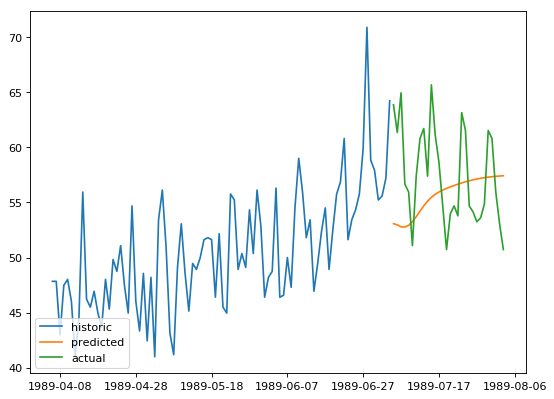

Actual, Predicted Values:
57.92 , 56.321503
54.86 , 56.4157
58.64 , 56.64493
55.94 , 56.857536
60.08 , 56.910625
58.099999999999994 , 56.872578
57.74 , 56.841896
59.540000000000006 , 56.864918
61.519999999999996 , 56.941204
58.64 , 57.050877
63.32 , 57.17174
65.84 , 57.286568
71.78 , 57.384933
66.2 , 57.46246
59.89999999999999 , 57.519096
60.440000000000005 , 57.55738
58.46 , 57.581024
51.26 , 57.593937
52.7 , 57.599648
59.0 , 57.60102
58.099999999999994 , 57.600166
58.099999999999994 , 57.59849
55.94 , 57.59684
57.74 , 57.595604
57.74 , 57.59491
68.9 , 57.594696
59.0 , 57.594822
62.78 , 57.59514
62.42 , 57.595505
62.42 , 57.595818


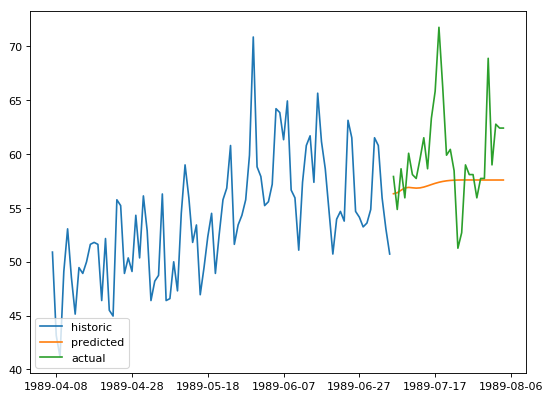

Actual, Predicted Values:
56.48 , 58.241413
61.519999999999996 , 58.17571
60.980000000000004 , 58.660698
53.6 , 59.20043
53.96 , 59.478683
58.64 , 59.56826
58.64 , 59.523933
57.92 , 59.373997
55.22 , 59.147408
56.120000000000005 , 58.876293
60.62 , 58.593742
60.980000000000004 , 58.328693
63.68 , 58.10155
60.08 , 57.922585
59.0 , 57.79308
55.4 , 57.707962
57.379999999999995 , 57.6587
63.14 , 57.63566
60.260000000000005 , 57.629772
65.48 , 57.63346
54.86 , 57.64106
57.2 , 57.64878
56.660000000000004 , 57.654472
61.34 , 57.657238
68.0 , 57.65705
62.6 , 57.65437
59.36 , 57.649902
61.7 , 57.64438
61.7 , 57.63844
63.14 , 57.632584


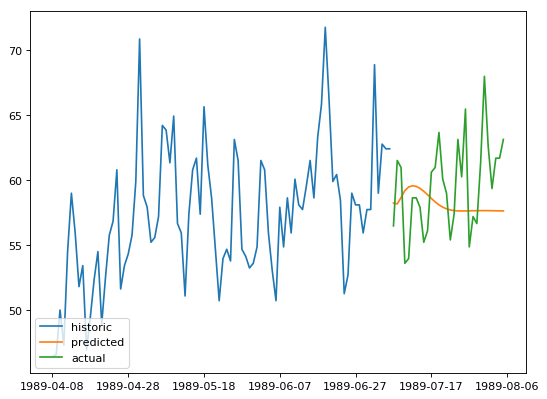

Actual, Predicted Values:
66.38 , 49.87911
66.74000000000001 , 49.463444
63.14 , 49.44647
66.2 , 49.778183
67.64 , 50.276928
66.74000000000001 , 50.712223
62.959999999999994 , 50.921192
57.56 , 50.88337
50.54 , 50.66737
55.4 , 50.35712
59.540000000000006 , 50.02091
59.0 , 49.707558
53.78 , 49.44916
48.56 , 49.263134
51.8 , 49.153225
59.0 , 49.110695
52.879999999999995 , 49.11636
52.879999999999995 , 49.143852
59.18 , 49.163864
59.0 , 49.149063
56.48 , 49.07886
54.5 , 48.942978
57.74 , 48.74292
60.8 , 48.490997
63.32 , 48.207207
62.42 , 47.915016
64.4 , 47.636917
69.08 , 47.390488
57.56 , 47.185505
51.620000000000005 , 47.02232


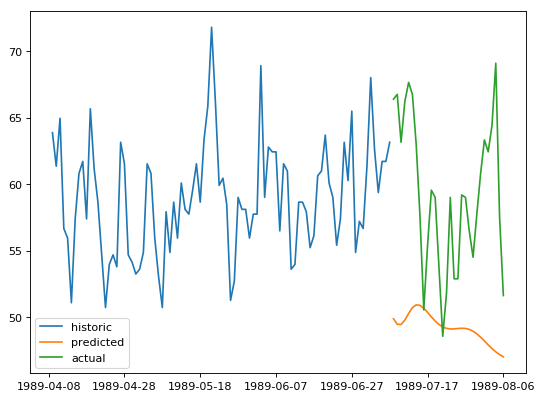

Actual, Predicted Values:
53.42 , 45.667183
55.94 , 45.239166
59.540000000000006 , 45.091446
58.46 , 45.59979
51.8 , 46.227024
53.96 , 46.73242
57.56 , 46.9667
62.6 , 46.881615
60.440000000000005 , 46.50289
59.36 , 45.92668
59.18 , 45.287025
58.46 , 44.70381
65.3 , 44.248894
61.519999999999996 , 43.941902
65.12 , 43.76259
59.18 , 43.669865
49.82 , 43.615513
50.36 , 43.564514
54.68 , 43.500786
55.76 , 43.42465
52.7 , 43.345966
56.84 , 43.27537
58.099999999999994 , 43.219746
58.46 , 43.180542
52.16 , 43.154846
54.86 , 43.137672
56.660000000000004 , 43.124287
52.7 , 43.11158
50.72 , 43.098396
48.02 , 43.085026


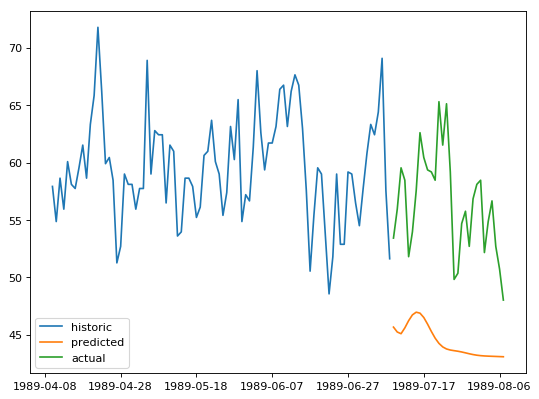

Actual, Predicted Values:
51.98 , 55.087215
49.1 , 56.729343
55.4 , 56.91673
57.02 , 56.468197
54.68 , 55.676823
57.74 , 54.766193
60.8 , 53.855736
55.94 , 52.997944
44.6 , 52.208828
40.82 , 51.49419
44.42 , 50.86057
56.660000000000004 , 50.31682
51.08 , 49.872322
54.14 , 49.534542
51.98 , 49.306625
50.36 , 49.18521
49.1 , 49.158646
48.02 , 49.206085
56.120000000000005 , 49.298103
48.379999999999995 , 49.399387
48.92 , 49.473576
47.66 , 49.489532
42.44 , 49.427395
40.1 , 49.282425
44.96 , 49.065243
50.0 , 48.798557
50.9 , 48.511616
51.26 , 48.234283
46.76 , 47.991837
42.980000000000004 , 47.801094


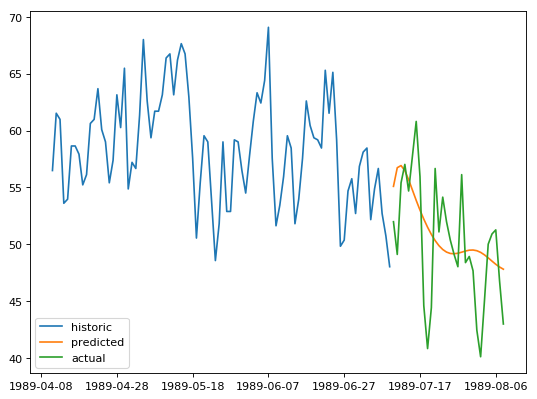

Actual, Predicted Values:
40.1 , 49.237083
42.980000000000004 , 49.57702
49.64 , 49.601616
49.46 , 49.437687
46.76 , 49.235676
47.120000000000005 , 49.00975
47.3 , 48.775246
50.72 , 48.539814
44.239999999999995 , 48.307655
42.8 , 48.0812
43.879999999999995 , 47.86199
46.04 , 47.65089
50.54 , 47.44789
44.96 , 47.25183
45.32 , 47.06018
52.52 , 46.86917
41.72 , 46.674282
39.92 , 46.471016
43.519999999999996 , 46.255936
48.74 , 46.02765
45.86 , 45.787533
46.58 , 45.5399
46.94 , 45.291508
48.379999999999995 , 45.050327
45.86 , 44.823948
51.08 , 44.617958
46.76 , 44.434902
46.22 , 44.274117
41.36 , 44.133026
42.620000000000005 , 44.007282


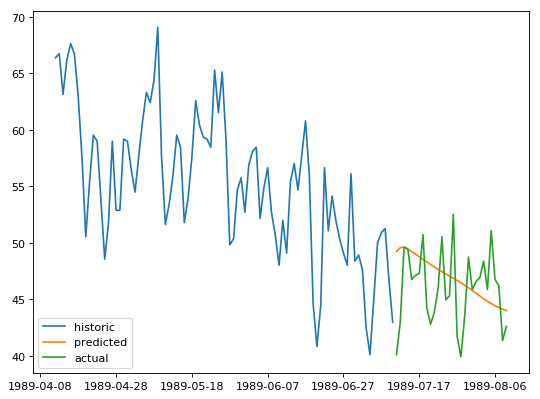

Actual, Predicted Values:
38.66 , 40.107647
42.08 , 39.196587
48.92 , 39.780804
45.32 , 40.300034
45.14 , 40.61204
45.86 , 41.004745
45.86 , 41.59367
48.74 , 42.32199
39.92 , 43.002556
42.26 , 43.469402
50.36 , 43.66593
50.36 , 43.64347
48.74 , 43.501755
41.72 , 43.335182
41.0 , 43.203384
45.68 , 43.126778
49.28 , 43.09778
50.72 , 43.09634
52.16 , 43.10258
48.379999999999995 , 43.103638
52.16 , 43.095078
44.239999999999995 , 43.078728
46.94 , 43.059246
49.46 , 43.041164
49.28 , 43.027252
49.64 , 43.018177
51.44 , 43.013084
48.56 , 43.01045
43.7 , 43.008842
46.58 , 43.007347


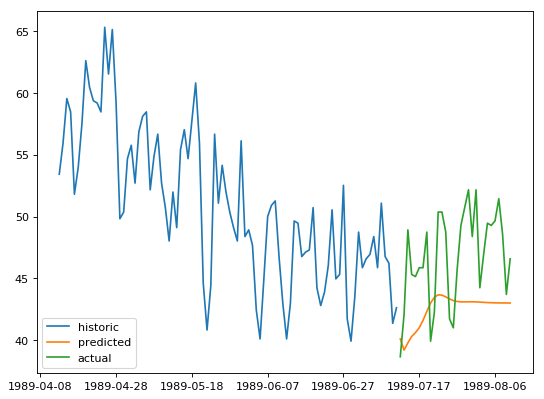

In [25]:
#print random plots for every 1000 steps
import matplotlib.dates as mdates

step = 30
offset = 365
prediction_time = 30


date_idx1 = trainN + 1 + offset - lag

date_idx2 = date_idx1 + lag + prediction_time


for i in range(10):
    
    dates = pandas_data['date'][date_idx1+i: date_idx2+i]
    dates1 = pd.to_datetime(dates, unit='s')
    dates1 = [mdates.date2num(d) for d in dates1]

    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    test_line = i * step + offset

    xLine = xTest[test_line,:]
    yLine = yTest[test_line,:]

    xLine = xLine.reshape(1, lag, 1)
    yHat = decode_sequence(xLine, prediction_time)
    hist = np.vstack((xLine.reshape(lag, 1), -1*np.ones(yLine.shape)))
    hist = scaler.inverse_transform(hist)*9/5 + 32
    hist[hist == 32] = np.nan

    plt.plot(dates1, hist)
    preds = np.vstack((-1*np.ones((lag, 1)), yHat[0,:]))
    preds = scaler.inverse_transform(preds)*9/5 + 32
    preds[preds == 32] = np.nan

    plt.plot(dates1, preds)
    acts = np.vstack((-1*np.ones((lag, 1)),yLine))
    acts = scaler.inverse_transform(acts)*9/5 + 32
    acts[acts == 32] = np.nan

    plt.plot(dates1, acts)
    plt.legend(['historic', 'predicted', 'actual'], loc='lower left')
    ax = plt.axes()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    print("Actual, Predicted Values:")
    for i, j in zip(yLine.flatten(), yHat.flatten()):
        i = scaler.inverse_transform(i)*9/5 + 32
        j = scaler.inverse_transform(j)*9/5 + 32
        i = i.flatten()[0]
        j = j.flatten()[0]
        print(i,",", j)
    plt.show()


In [15]:
encoder_model.save('models/DEEP_LSTMencoder.h5')
decoder_model.save('models/DEEP_LSTMdecoder.h5')

/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_3 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_3:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_3:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
